# Import Libraries and Define Functions

In [1]:
# Magic iPython command to enable plotting
%matplotlib inline

experiment='cxilu9218'
pullDataFromUser='igabalsk' # update me to mrware or igablsk
RESULTSPATH=('/cds/data/psdm/%s/%s/results/%s' % (experiment[0:3],experiment,pullDataFromUser)).strip()
# Load in the pythonBatchMagic |library
from scipy.ndimage import gaussian_filter1d
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from scipy.signal import lombscargle
def get_lombscargle(Qs, ts, signal):
    omegas = np.fft.fftshift(np.fft.fftfreq(n=ts.size,d=(ts[1]-ts[0])) )*2*np.pi
    goodOmegas = omegas[omegas>0]
    goodOmegas = np.linspace(np.min(goodOmegas),1*np.max(goodOmegas),len(goodOmegas))
    output = np.zeros((2*goodOmegas.size,Qs.size))
    nw = len(goodOmegas)
    for qIdx, q in enumerate(Qs):
        output[nw:,qIdx] = lombscargle(ts,signal[:,qIdx],goodOmegas,precenter=True)
        output[:nw,qIdx] = np.flip(output[nw:,qIdx],axis=0)
    return 1000*np.concatenate((-1*np.flip(goodOmegas),goodOmegas)), output

blur_f = 2
gf_f = lambda x: gaussian_filter1d(np.real(x),blur_f,axis=0)+1.0j*gaussian_filter1d(np.imag(x),blur_f,axis=0)

blur_ls = 1
gf_ls = lambda x: gaussian_filter1d(x,blur_ls,axis=0)

# Read in full theory scattering

In [4]:
theory = {}

import h5py
with h5py.File('mat/cs2_diffsig_theory_30trajs.mat','r') as f:
    for name, data in f.items():
        theory[name]=f[name][()]

# qAng - Dimensions (1, Nq) - q in inverse angstroms. 
# tt - Dimensions (1, nts) - Time vector.
# tc - Dimensions (1,ntc) - Extended time vector for convoluted signal.
# Wiam - Dimensions (Ntraj, Ntraj, Nq, nts) - Full scattering matrix (Imol + Iat), diagonal elements only.
# Iat - Dimensions (1, Nq) - Atomic scattering term. 
# WW - Dimensions (Nq, nts) - Total scattering for Ehrenfest wavefunction (just the average over Ntraj as equal weights) - all trajectories. 
# WWc - Dimensions (Nq, nts) - Convoluted signal - all trajectories.
# dW - Dimensions (Nq, nts) - Unconvoluted (raw) percentage difference signal - all trajectories.
# dWc - Dimensions (Nq, nts) - Convoluted percentage difference signal - all trajectories. 

(149,) (2401,) (2401, 149)


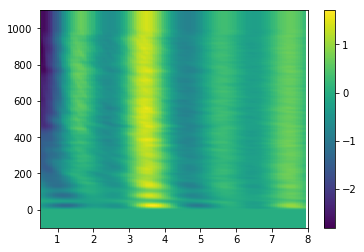

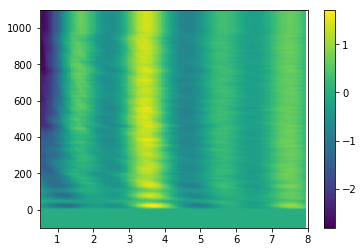

In [5]:
def rebin_theory(ts, ts_rebin, signal):
    dt = np.diff(ts_rebin)
    output = np.zeros((ts_rebin.size,signal.shape[-1]))
    for i,t in enumerate(ts_rebin[:-1]):
        tIdx = (ts>t)&(ts<t+dt[i])
        output[i,:] = np.nanmean(signal[tIdx,:],axis=0)
    return output

Qs, ts = theory['qAng'][(theory['qAng']>0.5)&(theory['qAng']<8)].flatten(), theory['tc'].flatten()
dWc = theory['dWc'][:,(theory['qAng']>0.5).flatten()&(theory['qAng']<8).flatten()]
print Qs.shape, ts.shape, dWc.shape
plt.figure()
plt.pcolormesh(Qs,ts,dWc)
plt.colorbar()
plt.xlim([0.5,8])
plt.show()

tbin_size = 2
ts_rebin = np.arange(np.min(ts),np.max(ts),tbin_size)
signal_rebin = rebin_theory(ts,ts_rebin,dWc)
# signal_rebin = gf_q(signal_rebin)
# signal_rebin = gf_t(signal_rebin)
plt.figure()
plt.pcolormesh(Qs,ts_rebin,signal_rebin)
plt.colorbar()
plt.xlim([0.5,8])
plt.show()

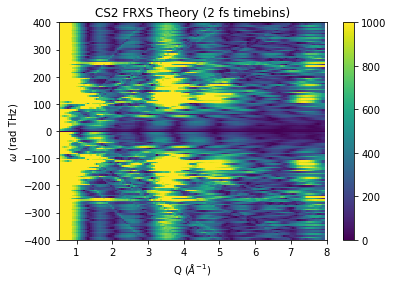

In [6]:
tmin,tmax = 0,1200
ts = ts_rebin
dWc = signal_rebin

ts_transform = ts[(ts>tmin)&(ts<tmax)]
dWc_transform = dWc[(ts>tmin)&(ts<tmax),:]
dWc_norm = dWc - 1*np.mean(dWc_transform,axis=0)
omegas = np.fft.fftshift(np.fft.fftfreq(n=ts_transform.size,d=np.mean(np.diff(ts_transform)/1000.)))*2*np.pi
dw = np.mean(np.diff(omegas))
omegas = omegas-dw/2
QQ,WW = np.meshgrid(Qs,omegas)
dWc_norm = dWc_transform - np.mean(dWc_transform,axis=0)
fft_theory = np.fft.fftshift(np.fft.fft(dWc_norm,axis=0),axes=0)
# fft_theory = gf_f(fft_theory)
plt.figure()
plt.pcolormesh(Qs,omegas,np.abs(WW)*np.abs(fft_theory))
plt.colorbar()
plt.xlim([0.5,8])
plt.ylim([-np.min((np.max(omegas),400)),np.min((np.max(omegas),400))])
plt.clim([0,1000])
plt.xlabel(r'Q ($\AA^{-1}$)')
plt.ylabel(r'$\omega$ (rad THz)')
plt.title('CS2 FRXS Theory (%d fs timebins)' % tbin_size)
plt.show()

In [ ]:
omegas_ls_theory, ls_theory = get_lombscargle(Qs,ts_transform,dWc_norm)
# ls_theory = gf_ls(ls_theory)
QQ_ls_theory,WW_ls_theory = np.meshgrid(Qs,omegas_ls_theory)
plt.figure()
plt.pcolormesh(Qs,omegas_ls_theory,np.abs(WW_ls_theory)*ls_theory)
plt.ylim([-np.min((np.max(omegas_ls_theory),400)),np.min((np.max(omegas_ls_theory),400))])
plt.xlim([0.5,8])
plt.clim([0,10])
plt.colorbar()
plt.xlabel(r'Q ($\AA^{-1}$)')
plt.ylabel(r'$\omega$ (rad THz)')
plt.title('CS2 Lomb-Scargle Theory (%d fs timebins)' % tbin_size)
plt.show()

## Check that Lomb-Scargle gives nice results for simple trajectories

In [ ]:
ts = np.linspace(0,1000,200)
qs = np.linspace(1,4,100)
f = 200
a = 0.1
def r(t,f,a):
    return a*np.sin(f*t/1000)+2.5
def r2(t,v,a):
    return 2.5+v*t/1000
QQ,TT = np.meshgrid(qs,ts)
s1 = np.sinc(QQ*r2(TT,f/2,a)/np.pi)
s2 = np.sinc(QQ*r(TT,1000,0.1)/np.pi)
s = s1+s2
wws,ls_ss = get_lombscargle(qs,ts,s)
omegas = np.fft.fftshift(np.fft.fftfreq(len(ts), d=np.mean(np.diff(ts))),axes=0)*1e3*2*np.pi
ft = np.fft.fftshift(np.fft.fft(s-np.mean(s,axis=0),axis=0),axes=0)

fig, ax = plt.subplots(2,2)
fig.set_size_inches(12, 9)
ax[0,0].plot(ts,r2(ts,f,a))
ax[0,0].set_title('Trajectory')
pcm1 = ax[0,1].pcolormesh(QQ,TT,s)
fig.colorbar(pcm1, ax=ax[0,1])
ax[0,1].set_title('S(Q,t)')
pcm2 = ax[1,0].pcolormesh(qs,wws,ls_ss,vmax=np.max(ls_ss)/10)
fig.colorbar(pcm2,ax=ax[1,0])
ax[1,0].set_title('Lomb-Scargle')
pcm3 = ax[1,1].pcolormesh(qs,omegas,np.abs(ft),vmax=1)
fig.colorbar(pcm3,ax=ax[1,1])
ax[1,1].set_title('FFT')
plt.show()

# Load atomic scattering form factors

In [ ]:
form_factors={}
with open('atomic_FF_coeffs_clean.csv', 'r') as f:
    lines = f.readlines()
    for line in lines:
        vals = line.split(',')
        element = vals[0]
        coeffs = [float(val) for val in vals[1:]]
        form_factors[element] = coeffs
        
def load_form_fact(Element):
    coeffs = form_factors[Element]
    t1 = lambda q: coeffs[0]*np.exp(-1*coeffs[1]*(q/(4*np.pi))**2)
    t2 = lambda q: coeffs[2]*np.exp(-1*coeffs[3]*(q/(4*np.pi))**2)
    t3 = lambda q: coeffs[4]*np.exp(-1*coeffs[5]*(q/(4*np.pi))**2)
    t4 = lambda q: coeffs[6]*np.exp(-1*coeffs[7]*(q/(4*np.pi))**2) + coeffs[8]
    ff = lambda q: t1(q)+t2(q)+t3(q)+t4(q)
    return ff

def load_xyz(filepath):
    with open(filepath,'r') as f:
        lines = f.readlines()
        numel_line = lines[0].strip()
        numel = int(numel_line[0])
        atoms = []
        for line in lines[2:]:
            line = line.strip()
            splitline = line.split()
            atom = [splitline[0]]
            for i in range(1,4):
                atom.append(float(splitline[i]))
            atoms.append(atom)
    return atoms

def isotropic_scattering(xyz,QQ):
    '''
    xyz : list of atoms and coordinates, i.e. [['C',0,0,0],['S',1.5,1.5,1.5],['S',1.5,1.5,1.5]]
    QQ : the array of Q values over which to generate scattering
    '''
    output = np.zeros(QQ.shape,dtype=float)
    for atom in xyz:
        output += np.abs(load_form_fact(atom[0])(QQ))**2
    for i in range(len(xyz)):
        for j in range(i+1,len(xyz)):
            atom1 = xyz[i][0]
            atom2 = xyz[j][0]
            xyz1 = np.array(xyz[i][1:])
            xyz2 = np.array(xyz[j][1:])
            ff1 = load_form_fact(atom1)
            ff2 = load_form_fact(atom2)
            r_ij = norm(xyz1-xyz2)
            output += 2*np.abs(ff1(QQ)*ff2(QQ))*np.sinc(1/np.pi*QQ*r_ij)
    return output

def trajectory_scattering(xyzs,QQ):
    '''
    xyzs : len(xyzs)=Nt, each entry is an xyz list that isotropic_scattering() eats
    QQ : the Q array to feed to isotropic_scattering()
    '''
    output = np.zeros((len(xyzs),QQ.size))
    for i, xyz in enumerate(xyzs):
        scattering = isotropic_scattering(xyz,QQ)
        output[i] = scattering
    return output

def generate_xyzs(geos, atoms):
    '''
    geos : (Natom,3,Nt) shaped array for a single trajectory
    atoms : list of strings of atom names corresponding to the Natom column in geos, i.e. ['C','S','S']
    '''
    from numpy.linalg import norm
    xyzs = []
    for i in range(geos.shape[-1]):
        xyz = []
        for j, atom in enumerate(atoms):
            xyz.append([atom,geos[j,0,i],geos[j,1,i],geos[j,2,i]])
        xyzs.append(xyz)
    return xyzs

def all_trajectory_scattering(allgeos,atoms,QQ):
    '''
    allgeos : array of individual geos that get fed into generate_xyzs(), shape (Natom,3,Ntraj,Nt)
    atoms : list of strings of atom names corresponding to the Natom column in geos, i.e. ['C','S','S']
    QQ : the Q array
    '''
    allgeos = allgeos.transpose(2,0,1,3)
    Ntraj = len(allgeos)
    for i, geos in enumerate(allgeos):
        print 'Trajectory', i
        xyzs = generate_xyzs(geos,atoms)
        if i==0:
            scattering = trajectory_scattering(xyzs,QQ)
        else:
            scattering += trajectory_scattering(xyzs,QQ)
    scattering /= Ntraj
    return scattering

def get_relgeos(geos,atoms):
    '''
    ~~~Parameters~~~
    geos : (Natom,3,Ntraj,Nt) shaped array of trajectories
    atoms : list of atom names, i.e. ['C','S','S']
    ~~~Returns~~~
    relgeos : (Natom_CHOOSE_2,Ntraj,Nt) array of distances between atom pairs
    atompairs : list of lists of atom pairs, i.e. [['C','S'],['C','S'],['S','S']]
    '''
    from scipy.special import comb
    from numpy.linalg import norm
    
    relgeos = np.zeros((comb(len(atoms),2,exact=True),geos.shape[2],geos.shape[3]))
    atompairs = []
    pairindex = 0
    for i in range(len(atoms)):
        for j in range(i+1,len(atoms)):
            relgeos[pairindex,:,:] = norm(geos[j,:,:,:]-geos[i,:,:,:],axis=0)
            atompair = [atoms[i],atoms[j]]
            atompairs.append(atompair)
            pairindex+=1
    return relgeos, atompairs

def get_final_v(relgeos,final_t):
    '''
    ~~~Parameters~~~
    relgeos : (Natom_CHOOSE_2,Ntraj,Nt) array of distances between atom pairs
    final_t : len=Ntraj array of dissociation times
    ~~~Returns~~~
    final_v : len=Ntraj array of dissociation velocities
    '''
    dissoc_pair_index = np.argmax(relgeos[:,:,-1],axis=0)

# Read in trajectories

In [ ]:
from scipy.io import loadmat, savemat
trajs_30 = loadmat('extended_trajs_30.mat')
trajs_213 = loadmat('extended_trajs_213.mat')

## Visualize some trajectories

In [ ]:
trajs = trajs_213

ts = np.linspace(0,1000,trajs['geometries'].shape[-1])
geos = trajs['geometries']
final_t = trajs['final_t'].flatten()
# final_t[24] = 450.

from numpy.linalg import norm
relgeos, atompairs = get_relgeos(geos,['C','S','S'])
bound_indices = [0, 1, 5, 10, 11, 12, 19, 23, 24, 28, 29]
dissoc_indices = [2, 3, 4, 6, 7, 8, 9, 13, 14, 15, 16, 17, 18, 20, 21, 22, 25, 26, 27]
index = 25
plt.figure()
# for j in range(30):
#     for i,pair in enumerate(atompairs):
#         plt.plot(ts,relgeos[i,j,:],label='%s-%s distance' % (pair[0],pair[1]))
for i,pair in enumerate(atompairs):
    plt.plot(ts,relgeos[i,index,:],label='%s-%s distance' % (pair[0],pair[1]))
plt.axvline(x=trajs['final_t'][0,index],color='red',linestyle='--')
plt.legend()
plt.title('Trajectory %d' %index)
plt.xlabel('Time (fs)')
plt.ylabel(r'Distance ($\AA$)')
# plt.ylim(0,50)
plt.show()

In [ ]:
plt.figure()
plt.hist(final_t,bins=100,label='Onset of dissociation')
plt.xlabel('Time (fs)')
plt.ylabel('# Trajectories')
plt.legend()
plt.show()

## Save scattering from certain trajectories (i.e. just bound trajectories)

In [ ]:
import os
import pickle
def load_obj(filename):
    try:
        with open(filename + '.pkl', 'rb') as f:
            print filename+" remembered!"
            return pickle.load(f)
    except IOError as e:
        print "IOError: Did you load the correct file? %s" % filename
        raise e
def save_obj(obj, filename ):
    with open(filename + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

QQ = np.linspace(0.5,8,200)

In [ ]:
# trajIdx = final_t<=999
# indices = list(np.where(trajIdx)[0])
# print indices

# allgeos = geos[:,:,trajIdx,:]
# scattering = all_trajectory_scattering(allgeos,['C','S','S'],QQ)
# # save_obj(scattering,'scattering_30_dissociated')

# plt.figure()
# plt.pcolormesh(QQ,ts,(scattering-scattering[0])/scattering[0])
# plt.show()

## Fourier analysis on selected trajectories

In [ ]:
scat = load_obj('scattering_213')
s = (scat-scat[0])/scat[0]

tbin_size = 5
tmin,tmax = 0,1000
ts_rebin = np.arange(tmin,tmax,tbin_size)
signal_rebin = rebin_theory(ts,ts_rebin,s)

fig,ax = plt.subplots(1,2)
fig.set_size_inches(12, 5)
ax[0].pcolormesh(QQ,ts,s)
ax[0].set_title('Theory')
ax[0].set_xlabel(r'Q ($\AA^{-1}$)')
ax[0].set_ylabel(r't (fs)')

ax[1].pcolormesh(QQ,ts_rebin,signal_rebin)
ax[1].set_title('Rebinned')
ax[1].set_xlabel(r'Q ($\AA^{-1}$)')
ax[1].set_ylabel(r't (fs)')
plt.show()

wws,ls_ss = get_lombscargle(QQ,ts_rebin,signal_rebin)
omegas = np.fft.fftshift(np.fft.fftfreq(len(ts_rebin), d=np.mean(np.diff(ts_rebin))),axes=0)*1e3*2*np.pi
ft = np.fft.fftshift(np.fft.fft(signal_rebin-np.mean(signal_rebin,axis=0),axis=0),axes=0)
_,WW = np.meshgrid(QQ,omegas)
_, WW_ls = np.meshgrid(QQ,wws)

In [ ]:
fig,ax = plt.subplots(1,2)
fig.set_size_inches(15, 5)
pcm1 = ax[0].pcolormesh(QQ,WW,np.abs(WW)*np.abs(ft),vmax=1e2)
ax[0].set_ylim(-600,600)
ax[0].set_title('FFT')
ax[0].set_xlabel(r'Q ($\AA^{-1}$)')
ax[0].set_ylabel(r'$\omega$ (rad-THz)')
fig.colorbar(pcm1,ax=ax[0])

pcm1 = ax[1].pcolormesh(QQ,WW_ls,np.abs(WW_ls)*np.abs(ls_ss),vmax=1e-1)
ax[1].set_ylim(-600,600)
ax[1].set_title('Lomb-Scargle')
ax[1].set_xlabel(r'Q ($\AA^{-1}$)')
ax[1].set_ylabel(r'$\omega$ (rad-THz)')
fig.colorbar(pcm2,ax=ax[1])
plt.show()

In [ ]:
print relgeos.shape
# find index of dissociated atom
maxdistancemask = relgeos[:,:,-1]==np.amax(relgeos[:,:,-1],axis=0)
# find trajectories that were propagated properly
goodtrajmask = np.sum(relgeos[:,:,-1]==np.amax(relgeos[:,:,-1],axis=0),axis=0)==1
numgoodtraj = np.sum(maxdistancemask & goodtrajmask)
finalfilt = np.nonzero(maxdistancemask & goodtrajmask)

finalpos = relgeos[finalfilt][:,-1]
ts_repeated = np.repeat(np.expand_dims(ts,0),numgoodtraj,axis=0)
final_t_repeated = np.repeat(np.expand_dims(final_t[goodtrajmask],1),relgeos.shape[-1],axis=1)
startpos = relgeos[finalfilt][ts_repeated == final_t_repeated]

final_v = (finalpos - startpos)/(1000-final_t[goodtrajmask])*1000
final_v = final_v[~np.isnan(final_v) & (final_v<200)]


plt.figure()
plt.hist(finalpos[finalpos<200],bins=100,alpha=0.7,label='Final Pos')
plt.hist(startpos[startpos<200],bins=100,alpha=0.7,label='Start Pos')
plt.xlabel(r'Position ($\AA$)')
plt.ylabel('# Trajectories')
plt.legend()
plt.show()

plt.figure()
plt.hist(final_v[final_v<200],bins=50,label='Final Vel')
plt.xlabel(r'Velocity ($\AA$/ps)')
plt.ylabel('# Trajectories')
plt.legend()
plt.show()